<a href="https://colab.research.google.com/github/arshjeevs/GDSC-AIML-FinetuneBert/blob/main/Finetune_Bert_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
from datasets import load_dataset

In [3]:
model = TFAutoModel.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [5]:
inputs = tokenizer(['Hello world', 'Hi how are you'], padding=True, truncation=True,
                  return_tensors='tf')
inputs

{'input_ids': <tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[ 101, 7592, 2088,  102,    0,    0],
       [ 101, 7632, 2129, 2024, 2017,  102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [6]:
output = model(inputs)
output

TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(2, 6, 768), dtype=float32, numpy=
array([[[-0.16888338,  0.13606317, -0.13940048, ..., -0.6251124 ,
          0.05217258,  0.36714536],
        [-0.36327428,  0.14121838,  0.8799863 , ...,  0.1043303 ,
          0.2887567 ,  0.37267867],
        [-0.6985949 , -0.69879764,  0.06450213, ..., -0.22103655,
          0.00986852, -0.5939797 ],
        [ 0.83098346,  0.1236672 , -0.15119052, ...,  0.10309628,
         -0.6779264 , -0.26285213],
        [-0.40266627, -0.01928282,  0.5732499 , ..., -0.20656854,
          0.02338545,  0.20126297],
        [-0.6228407 , -0.2745354 ,  0.18117562, ..., -0.12944865,
         -0.03839097, -0.05733195]],

       [[ 0.09286568, -0.02636383, -0.12239324, ..., -0.21063548,
          0.17386365,  0.17250982],
        [ 0.40742064, -0.05931018,  0.5523468 , ..., -0.6790569 ,
          0.65557426, -0.29456508],
        [-0.21155252, -0.6858645 , -0.46280813, ...,  0.1527852 

In [7]:
emotions = load_dataset('SetFit/emotion')

README.md:   0%|          | 0.00/194 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


train.jsonl:   0%|          | 0.00/2.23M [00:00<?, ?B/s]

validation.jsonl:   0%|          | 0.00/276k [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/279k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [8]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
})

In [9]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [10]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [11]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [12]:
emotions_encoded.set_format('tf',columns=['input_ids', 'attention_mask', 'token_type_ids', 'label'])

BATCH_SIZE = 64

def order(inp):
    data = list(inp.values())
    return {
        'input_ids': data[1],
        'attention_mask': data[2],
        'token_type_ids': data[3]
    }, data[0]

train_dataset = tf.data.Dataset.from_tensor_slices(emotions_encoded['train'][:])
train_dataset = train_dataset.batch(BATCH_SIZE).shuffle(1000)
train_dataset = train_dataset.map(order, num_parallel_calls=tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(emotions_encoded['test'][:])
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.map(order, num_parallel_calls=tf.data.AUTOTUNE)

In [13]:
inp, out = next(iter(train_dataset))
print(inp, '\n\n', out)

{'input_ids': <tf.Tensor: shape=(64, 87), dtype=int64, numpy=
array([[  101,  1045, 19179, ...,     0,     0,     0],
       [  101,  1045,  2001, ...,     0,     0,     0],
       [  101,  1045,  2442, ...,     0,     0,     0],
       ...,
       [  101,  1045,  2031, ...,     0,     0,     0],
       [  101,  1045,  2031, ...,     0,     0,     0],
       [  101,  5665,  2228, ...,     0,     0,     0]])>, 'attention_mask': <tf.Tensor: shape=(64, 87), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'token_type_ids': <tf.Tensor: shape=(64, 87), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>} 

 tf.Tensor(
[0 0 1 3 3 1 1 1 0 1 4 1 0 

In [14]:
class BERTForClassification(tf.keras.Model):

    def __init__(self, bert_model, num_classes):
        super().__init__()
        self.bert = bert_model
        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.bert(inputs)[1]
        return self.fc(x)

In [18]:
classifier = BERTForClassification(model, num_classes=6)

classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [19]:
history = classifier.fit(
    train_dataset,
    epochs=1,
)

250/250 [==============================] - 335s 1s/step - loss: 1.2669 - accuracy: 0.5042


In [20]:
classifier.evaluate(test_dataset)

32/32 [==============================] - 11s 253ms/step - loss: 0.4739 - accuracy: 0.8380


[0.4739350974559784, 0.8379999995231628]

In [21]:
classifier.predict(test_dataset)

32/32 [==============================] - 11s 251ms/step


array([[0.48552513, 0.02224077, 0.00382098, 0.47115108, 0.01102244,
        0.00623967],
       [0.9664873 , 0.0029205 , 0.0046183 , 0.02197553, 0.00241517,
        0.00158321],
       [0.9646032 , 0.00375591, 0.00340177, 0.02171114, 0.00422768,
        0.00230031],
       ...,
       [0.00572094, 0.95008606, 0.03263929, 0.00301193, 0.00181084,
        0.00673095],
       [0.00447952, 0.9597986 , 0.01133013, 0.00268015, 0.00625327,
        0.01545842],
       [0.02434621, 0.02268156, 0.0095332 , 0.01293387, 0.69697744,
        0.2335277 ]], dtype=float32)

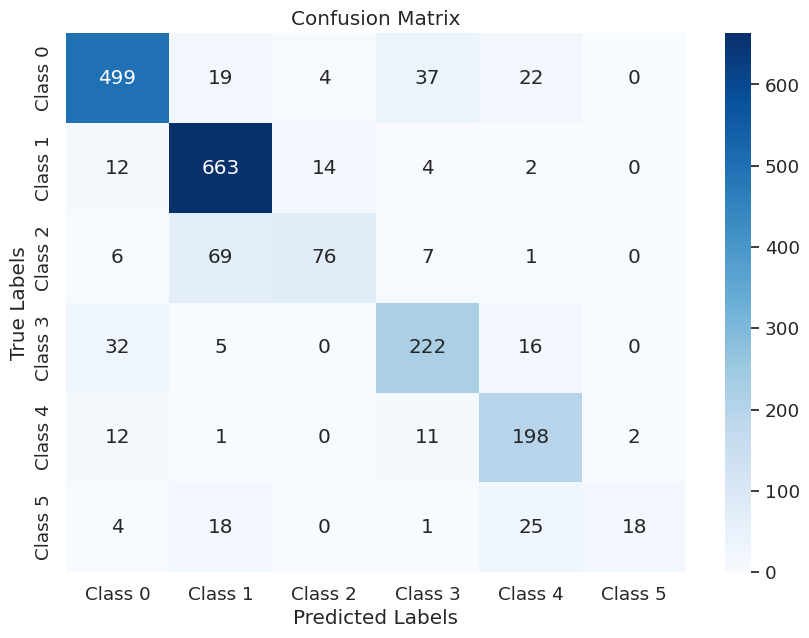


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       581
           1       0.86      0.95      0.90       695
           2       0.81      0.48      0.60       159
           3       0.79      0.81      0.80       275
           4       0.75      0.88      0.81       224
           5       0.90      0.27      0.42        66

    accuracy                           0.84      2000
   macro avg       0.83      0.71      0.73      2000
weighted avg       0.84      0.84      0.83      2000



In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

true_labels = []
predicted_labels = []

for inputs, labels in test_dataset:
    true_labels.extend(labels.numpy())
    logits = classifier.predict(inputs, verbose=0)
    preds = np.argmax(logits, axis=1)
    predicted_labels.extend(preds)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.set(font_scale=1.2)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"Class {i}" for i in range(conf_matrix.shape[1])],
            yticklabels=[f"Class {i}" for i in range(conf_matrix.shape[0])],
            cbar=True)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))